In [1]:
import numpy as np
import pandas as pd
import random
import math
from statsmodels.stats.multitest import fdrcorrection
from scipy.stats import zscore
import os
working_dir = "/Users/nkarisan/PycharmProjects/BTC_Cell_Line_Atlas_Manuscript"
os.chdir(working_dir)

import scripts.io_library as io_library
io_library.input_dir = 'input_data/'
io_library.output_dir = 'Figure6/output_fig6/'

from scripts.io_library import MyLib
from scripts.utils import Utils
from scripts.visualization import MyVisualization
from scripts.clustering_utils import Clustering

In [2]:
import matplotlib
seed = 2023
random.seed(seed)
np.random.seed(seed)

matplotlib.use("nbagg")


%matplotlib inline
%config InlineBackend.figure_format = "retina"


%load_ext autoreload
%autoreload 2

In [3]:
gene_effect_file = 'Main_Data/CRISPR/CRISPR.csv'
all_gene_effect_df = MyLib.load_csv(gene_effect_file, index_col=0)
all_gene_effect_df = all_gene_effect_df.T
all_gene_effect_df = all_gene_effect_df.dropna(axis=1)
all_gene_effect_df = all_gene_effect_df.rename(columns={c:c.split(' (')[0] for c in all_gene_effect_df.columns})

upset_file = 'cell_lines_master_upset_2024-4-13.csv'
raw_upset_df = MyLib.load_csv(upset_file, index_col=0)
upset_df = raw_upset_df[raw_upset_df['Subtype'] != 'HCC']
upset_df = upset_df[["Subtype", 'DepMap_ID', 'RNA', 'CRISPR']]
print(f'upset shape: {upset_df.shape}')

crispr_upset_df = raw_upset_df[(raw_upset_df['CRISPR']==1) & (raw_upset_df['Subtype'] != 'HCC')]
gene_effect_df = all_gene_effect_df.loc[crispr_upset_df.index,:]
print(f'gene effect shape: {gene_effect_df.shape}')

rna_file = 'Main_Data/RNA/rna_cell_lines.csv'
all_rna_df = MyLib.load_csv(rna_file, index_col=0).T

rna_upset_df = raw_upset_df[(raw_upset_df['RNA']==1) & (raw_upset_df['Subtype'] != 'HCC')]
rna_df = all_rna_df.loc[rna_upset_df.index, :]
rna_fold_df = rna_df.apply(lambda x:x-x.median())
print(f'rna shape: {rna_df.shape}')


proteomics_file = 'Main_Data/Proteomics/proteomics_collapsed.csv'
all_proteomics_df = MyLib.load_csv(proteomics_file, index_col=0).T
# proteomics_df = proteomics_df.dropna(axis=1, how ='all')
all_proteomics_df = Clustering.filter_sparse_samples(all_proteomics_df, max_allowed_nans_zeros_frac=0.4)
proteins_upset_df = raw_upset_df[(raw_upset_df['Protein']==1) & (raw_upset_df['Subtype'] != 'HCC')]
proteomics_df = all_proteomics_df.loc[proteins_upset_df.index,:]
proteomics_mad_df = proteomics_df.apply(Clustering.mad_normalize)
print(f'proteomics_mad shape:{proteomics_mad_df.shape}')


all_proteomics_mad_df = all_proteomics_df.apply(Clustering.mad_normalize)
print(f'all_proteomics_mad shape:{all_proteomics_mad_df.shape}')

proteins_key_file = 'Additional_Data/Selected_Lists/protein_gene_mapping.csv'
proteomics_key_df = MyLib.load_csv(proteins_key_file, index_col=0)

input_data/Main_Data/CRISPR/CRISPR.csv  is loaded, shape:  (18443, 60)

input_data/cell_lines_master_upset_2024-4-13.csv  is loaded, shape:  (87, 10)

upset shape: (63, 4)
gene effect shape: (39, 17787)
input_data/Main_Data/RNA/rna_cell_lines.csv  is loaded, shape:  (17649, 79)

rna shape: (56, 17649)
input_data/Main_Data/Proteomics/proteomics_collapsed.csv  is loaded, shape:  (14411, 75)

proteomics_mad shape:(58, 8284)
all_proteomics_mad shape:(75, 8284)
input_data/Additional_Data/Selected_Lists/protein_gene_mapping.csv  is loaded, shape:  (11421, 1)



In [4]:
ccle_cripsr_file = 'Additional_Data/DepMap/CRISPRGeneEffect_internal-23q2-1e49_v97_filtered_by_public_ids.csv'
ccle_crispr_df = MyLib.load_csv(ccle_cripsr_file, index_col=0)
ccle_crispr_df = ccle_crispr_df.dropna(axis=1)
ccle_crispr_df = ccle_crispr_df.rename(columns={c:c.split(' (')[0] for c in ccle_crispr_df.columns})
print(f'ccle_crispr_df shape:{ccle_crispr_df.shape}')

other_ccle_crispr_df = ccle_crispr_df[~ccle_crispr_df.index.isin(upset_df['DepMap_ID'])]
print(f'other_ccle_crispr_df shape:{other_ccle_crispr_df.shape}')

ccle_rna_file = 'Additional_Data/DepMap/RNA_20Q2/public-20q2_v18-ccle-expression.csv'
ccle_rna_df = MyLib.load_csv(ccle_rna_file, index_col=0)
ccle_rna_df = ccle_rna_df.dropna(axis=1)
ccle_rna_df = ccle_rna_df.rename(columns={c:c.split(' (')[0] for c in ccle_rna_df.columns})
ccle_rna_fold_df = ccle_rna_df.apply(lambda x:x-x.median())
print(f'ccle_rna_df shape: {ccle_rna_df.shape}')

other_ccle_rna_df = ccle_rna_df[~ccle_rna_df.index.isin(upset_df['DepMap_ID'])]
other_ccle_rna_fold_df = ccle_rna_fold_df.loc[other_ccle_rna_df.index]
# other_ccle_rna_df, t = Utils.match_rows_df(ccle_rna_df, other_ccle_crispr_df)
print(f'other_ccle_rna_df shape: {other_ccle_rna_df.shape}')

input_data/Additional_Data/DepMap/CRISPRGeneEffect_internal-23q2-1e49_v97_filtered_by_public_ids.csv  is loaded, shape:  (1100, 18443)

ccle_crispr_df shape:(1100, 17107)
other_ccle_crispr_df shape:(1061, 17107)
input_data/Additional_Data/DepMap/RNA_20Q2/public-20q2_v18-ccle-expression.csv  is loaded, shape:  (1304, 19144)

ccle_rna_df shape: (1304, 19144)
other_ccle_rna_df shape: (1264, 19144)


In [5]:
points_color = '#6b676e'
line_color = '#C1914B'

## ELMO2 vs ILK (A0A0A0MTH3)

p-value:  0.012732372754262557


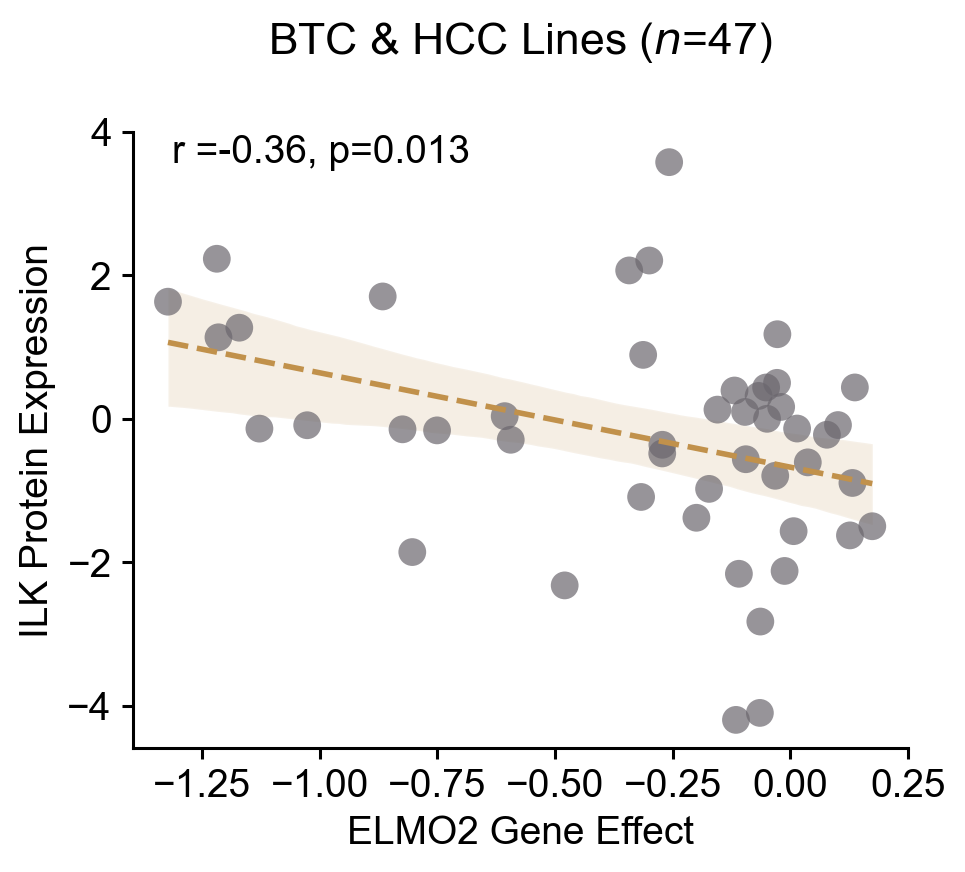

In [43]:
x_gene = 'ELMO2'
y_gene =  'A0A0A0MTH3' #'ILK'
x, y = Utils.match_rows_df(all_gene_effect_df[[x_gene]], all_proteomics_mad_df[[y_gene]])
df = pd.concat([x, y], axis=1)
df = df.dropna(axis=0)
df.columns=['gene_effect', 'protein']

MyVisualization.reg_plot(data_df=df, x_col='gene_effect', y_col='protein', title=f'BTC & HCC Lines ($n$={df.shape[0]})', points_color_code=points_color, line_color_code=line_color, xlabel=f'{x_gene} Gene Effect',  ylabel=f"{proteomics_key_df.loc[y_gene, 'GeneName']} Protein Expression", marker='o', title_height=1.1, text_height=.95,  ytick_step=2, xtick_step=0.25, ylim_top=4, xlim_right=.25, file_name=f'{x_gene}_{y_gene}')

## ELMO2 vs ARHGEF16 (ARHGG)

p-value:  4.46766380968017e-05


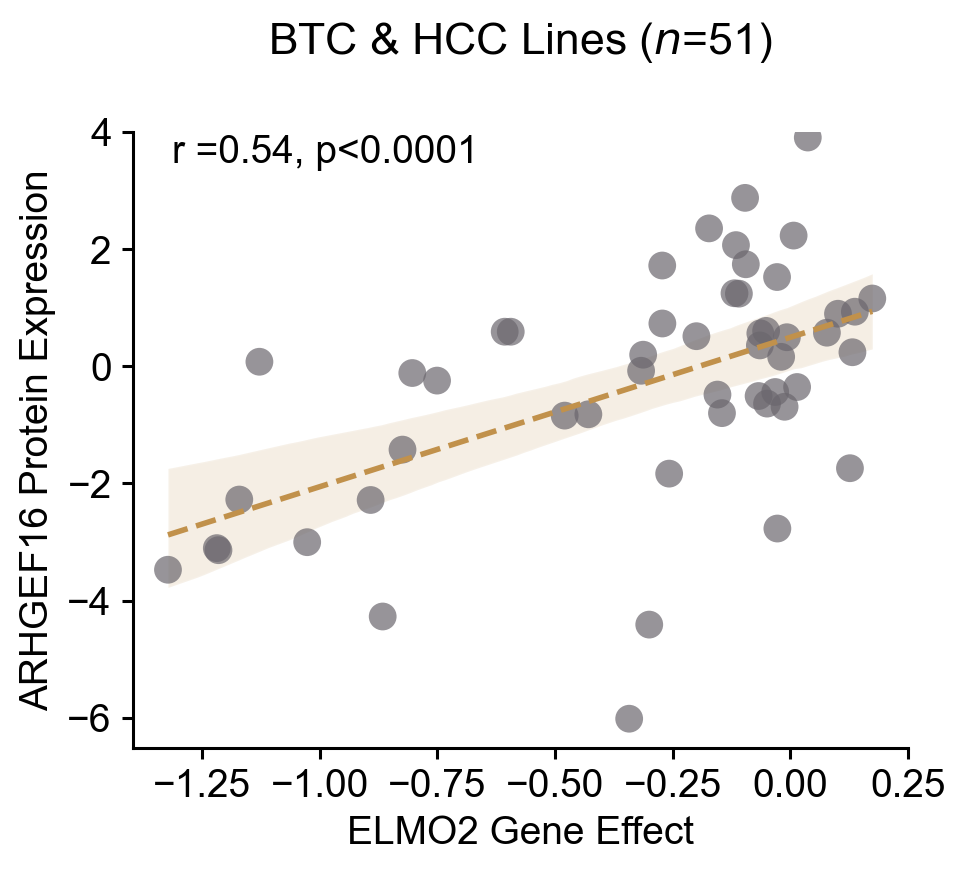

In [44]:
x_gene = 'ELMO2'
y_gene =  'ARHGG' 
x, y = Utils.match_rows_df(all_gene_effect_df[[x_gene]], all_proteomics_mad_df[[y_gene]])
df = pd.concat([x, y], axis=1)
df = df.dropna(axis=0)
df.columns=['gene_effect', 'protein']

MyVisualization.reg_plot(data_df=df, x_col='gene_effect', y_col='protein', title=f'BTC & HCC Lines ($n$={df.shape[0]})', points_color_code=points_color, line_color_code=line_color, xlabel=f'{x_gene} Gene Effect',  ylabel=f"{proteomics_key_df.loc[y_gene, 'GeneName']} Protein Expression", marker='o', title_height=1.1, text_height=.95,   ytick_step=2, xtick_step=0.25, xlim_right=.25, ylim_top=4, file_name=f'{x_gene}_{y_gene}')

## ELMO2 Multiple Testing Corrections

In [45]:
gene = 'ELMO2'
genes_file = 'Additional_Data/Selected_Lists/MHT/ELMO2.xlsx'
hypotheses_l = MyLib.load_xls(genes_file, sheet_no=0)['ProteinID'].values.tolist()
hypotheses_l = [h.split('_H')[0] for h in hypotheses_l]
print('Number of hypotheses: ', len(hypotheses_l))


Number of hypotheses:  1534



File  Figure6/output_fig6/BTC&HCC_ELMO2_gene_effect_corr_rna.csv saved, shape: (1534, 4)


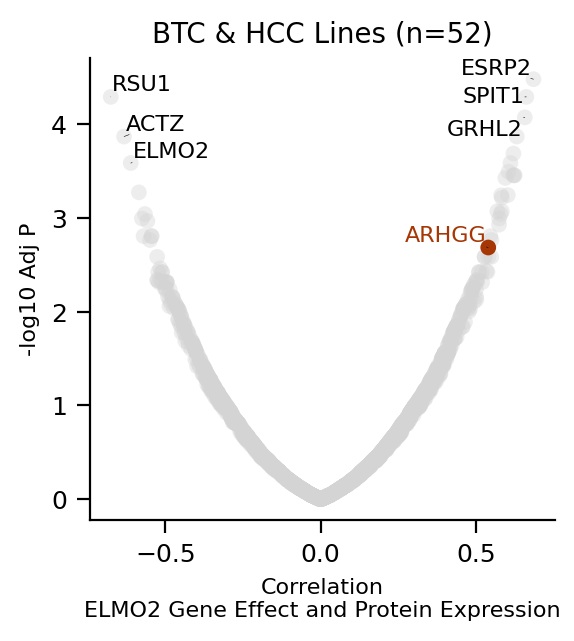

feature       ARHGG
corr       0.539128
p-value    0.000045
q-value    0.002077
color       #A63603
Name: ARHGG, dtype: object

In [46]:
selected_genes_dic = {'ARHGG':'#A63603'}
x, y = Utils.match_rows_df(all_gene_effect_df[[gene]], all_proteomics_mad_df[hypotheses_l])
corr_res_df = Utils.statistical_test_and_volcano_plot(x[[gene]], y, col=gene, test='correlation', xlabel='Correlation\nELMO2 Gene Effect and Protein Expression',  force_points=.6, force_text=1., selected_genes_dic=selected_genes_dic, cut_off_labels=3, save_file=f'BTC&HCC_{gene}_gene_effect_corr_rna.csv',  title=f'BTC & HCC Lines (n={y.shape[0]})', axis_label_fontsize=8)
corr_res_df.loc['ARHGG',:]

## FGFR1 vs CDH1 (A0A087WXI5)

p-value:  0.00021081502925245738


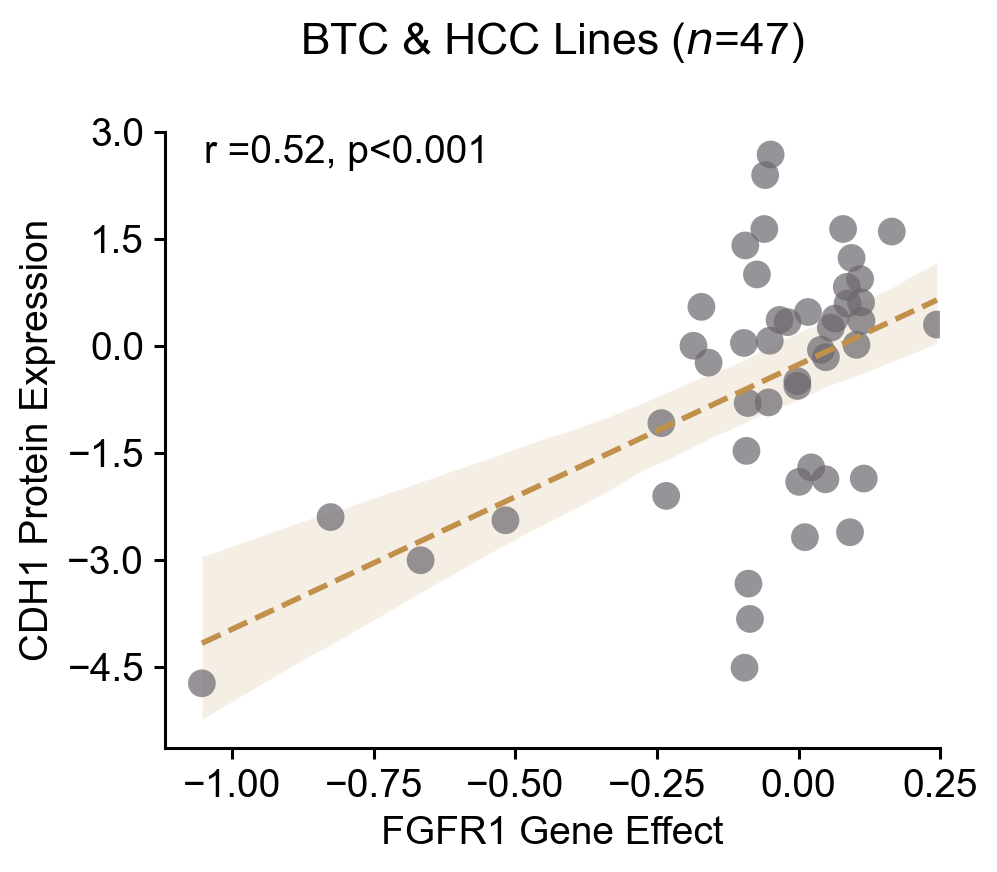

In [47]:
x_gene = 'FGFR1'
y_gene =  'A0A087WXI5'
x, y = Utils.match_rows_df(all_gene_effect_df[[x_gene]], all_proteomics_mad_df[[y_gene]])
df = pd.concat([x, y], axis=1)
df = df.dropna(axis=0)
df.columns=['gene_effect', 'protein']

MyVisualization.reg_plot(data_df=df, x_col='gene_effect', y_col='protein', title=f'BTC & HCC Lines ($n$={df.shape[0]})', points_color_code=points_color, line_color_code=line_color, xlabel=f'{x_gene} Gene Effect',  ylabel=f"{proteomics_key_df.loc[y_gene, 'GeneName']} Protein Expression", marker='o', title_height=1.1, text_height=.95,  ytick_step=1.5, xtick_step=0.25, ylim_top=3, xlim_right=.25, file_name=f'{x_gene}_{y_gene}')

## ITGB5 vs CRK 

p-value:  0.03205002826164306


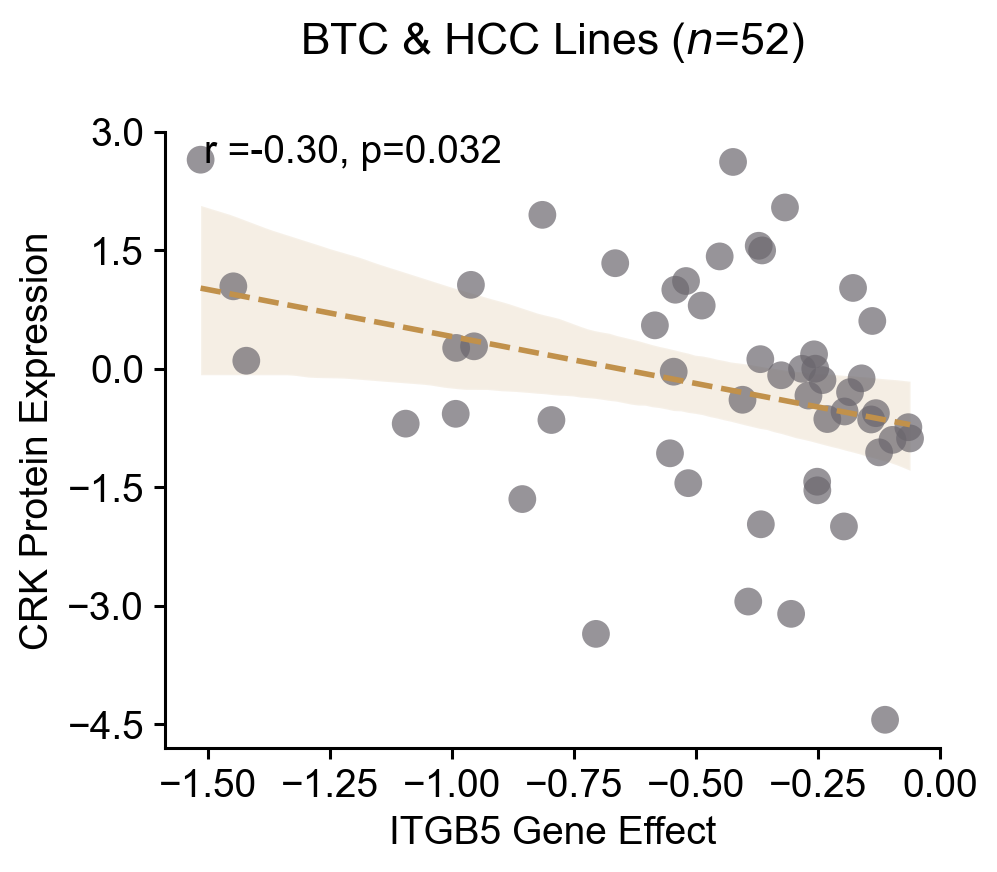

In [48]:
x_gene = 'ITGB5'
y_gene =  'CRK'
x, y = Utils.match_rows_df(all_gene_effect_df[[x_gene]], all_proteomics_mad_df[[y_gene]])
df = pd.concat([x, y], axis=1)
df = df.dropna(axis=0)
df.columns=['gene_effect', 'protein']

MyVisualization.reg_plot(data_df=df, x_col='gene_effect', y_col='protein', title=f'BTC & HCC Lines ($n$={df.shape[0]})', points_color_code=points_color, line_color_code=line_color, xlabel=f'{x_gene} Gene Effect',  ylabel=f"{proteomics_key_df.loc[y_gene, 'GeneName']} Protein Expression", marker='o', title_height=1.1, text_height=.95,   ytick_step=1.5, xtick_step=0.25, ylim_top=3, xlim_right=0,  file_name=f'{x_gene}_{y_gene}')

## HNF1A vs YWHAZ (1433Z)

p-value:  0.05255768020007118


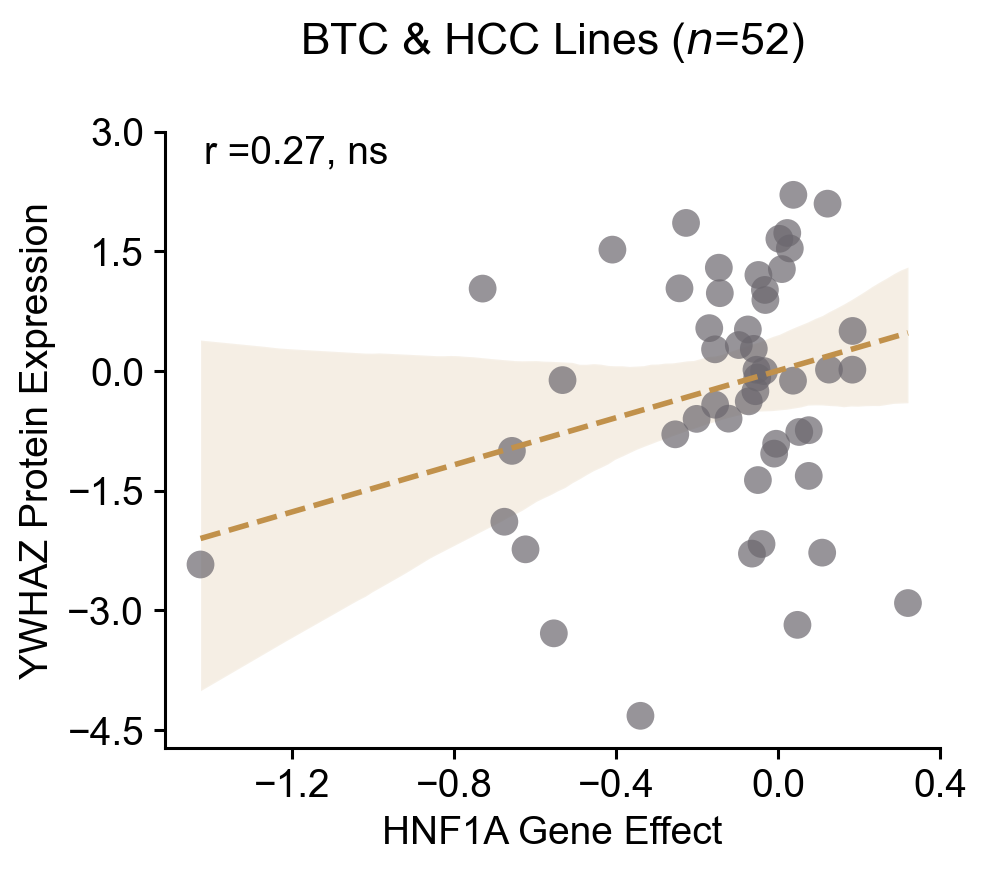

In [49]:
x_gene = 'HNF1A'
y_gene =  '1433Z'
x, y = Utils.match_rows_df(all_gene_effect_df[[x_gene]], all_proteomics_mad_df[[y_gene]])
df = pd.concat([x, y], axis=1)
df = df.dropna(axis=0)
df.columns=['gene_effect', 'protein']

MyVisualization.reg_plot(data_df=df, x_col='gene_effect', y_col='protein', title=f'BTC & HCC Lines ($n$={df.shape[0]})', points_color_code=points_color, line_color_code=line_color, xlabel=f'{x_gene} Gene Effect',  ylabel=f"{proteomics_key_df.loc[y_gene, 'GeneName']} Protein Expression", marker='o', title_height=1.1, text_height=.95,  ytick_step=1.5, xtick_step=0.4, ylim_top=3,xlim_right=.4 , file_name=f'{x_gene}_{y_gene}')

## TYMS vs UGGT1 (UGGG1)

p-value:  0.012604901608798336


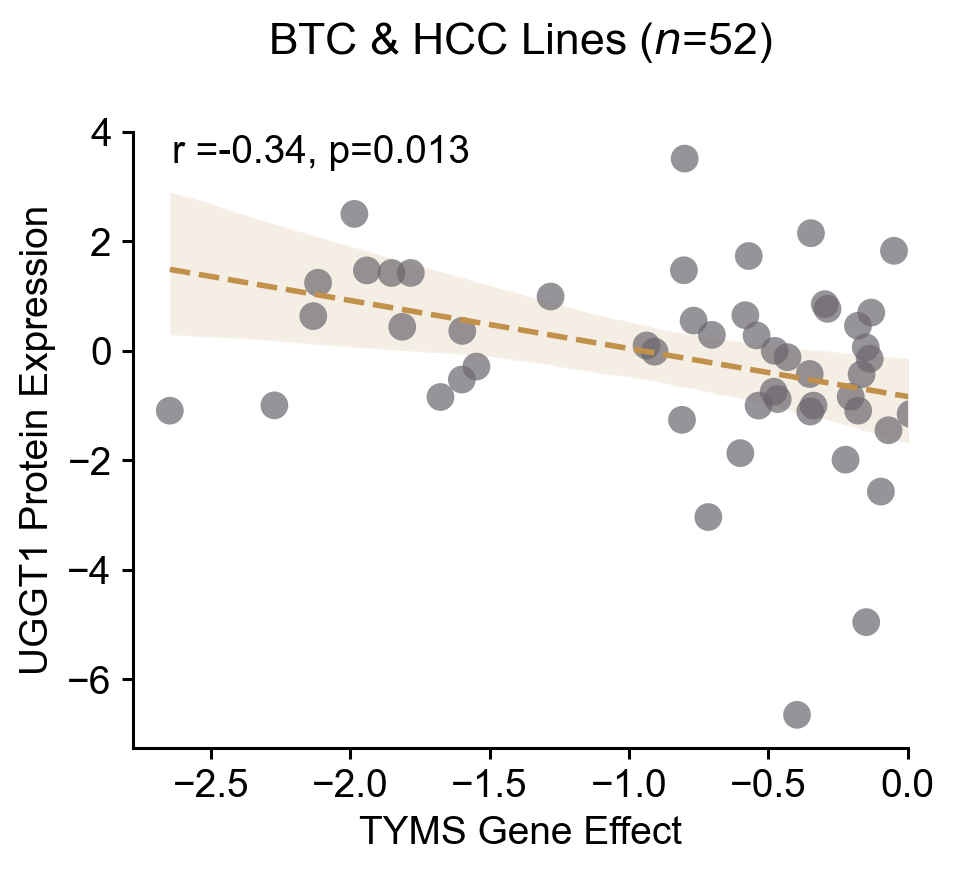

In [50]:
x_gene = 'TYMS'
y_gene =  'UGGG1'
x, y = Utils.match_rows_df(all_gene_effect_df[[x_gene]], all_proteomics_mad_df[[y_gene]])
df = pd.concat([x, y], axis=1)
df = df.dropna(axis=0)
df.columns=['gene_effect', 'protein']

MyVisualization.reg_plot(data_df=df, x_col='gene_effect', y_col='protein', title=f'BTC & HCC Lines ($n$={df.shape[0]})', points_color_code=points_color, line_color_code=line_color, xlabel=f'{x_gene} Gene Effect',  ylabel=f"{proteomics_key_df.loc[y_gene, 'GeneName']} Protein Expression", marker='o', title_height=1.1, text_height=.95,   ytick_step=2, xtick_step=0.5, ylim_top=4, xlim_right=0,
                          file_name=f'{x_gene}_{y_gene}')

## GRHL2 vs ESRP2

p-value:  0.005646008369523043


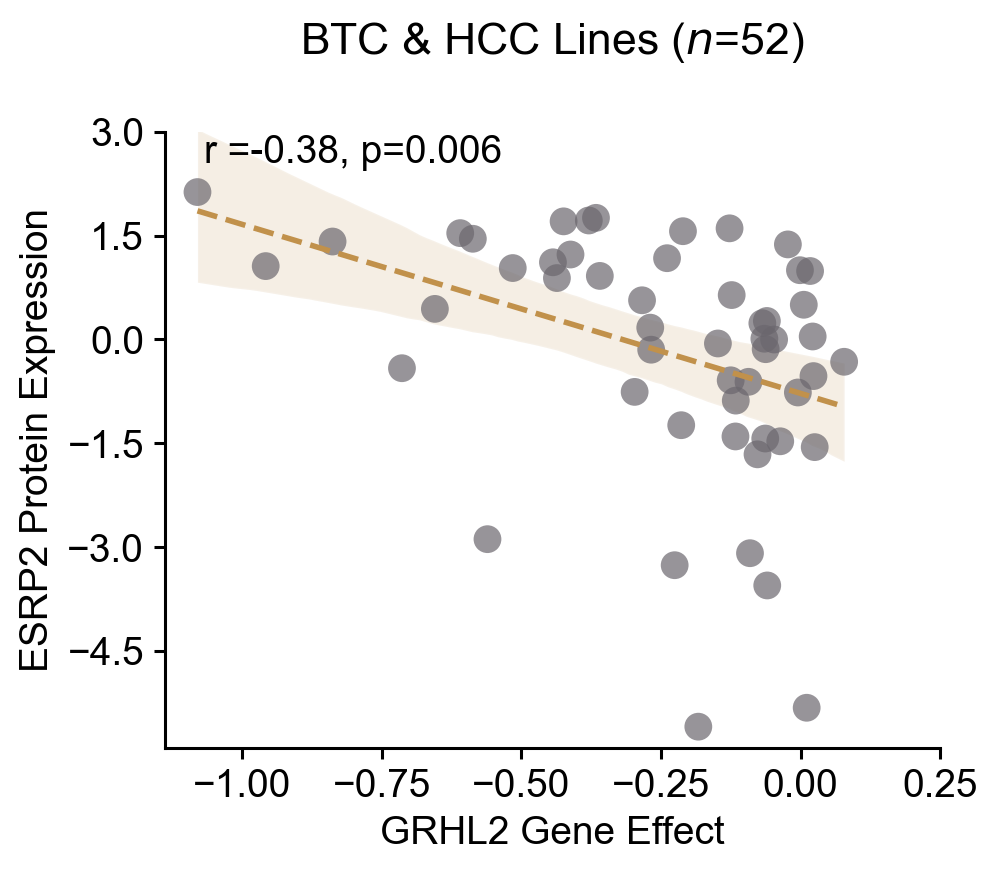

In [51]:
x_gene = 'GRHL2'
y_gene =  'ESRP2'
x, y = Utils.match_rows_df(all_gene_effect_df[[x_gene]], all_proteomics_mad_df[[y_gene]])
df = pd.concat([x, y], axis=1)
df = df.dropna(axis=0)
df.columns=['gene_effect', 'protein']

MyVisualization.reg_plot(data_df=df, x_col='gene_effect', y_col='protein', title=f'BTC & HCC Lines ($n$={df.shape[0]})', points_color_code=points_color, line_color_code=line_color, xlabel=f'{x_gene} Gene Effect',  ylabel=f"{proteomics_key_df.loc[y_gene, 'GeneName']} Protein Expression", marker='o', title_height=1.1, text_height=.95,   ytick_step=1.5, xtick_step=0.25, ylim_top=3, ylim_bottom=-5.9 ,xlim_right=.25, file_name=f'{x_gene}_{y_gene}')

## GRHL2 Multiple Testing Corrections

In [52]:
proteomics_key_df

,GeneName
ProteinID,
RS10,RPS10
FLNA,FLNA
PRCC,PRCC
SRSF7,SRSF7
OCAD2,OCIAD2
...,...
X6R4D2,HID1
AGAL,GLA
ZN260,ZNF260


In [53]:
gene = 'GRHL2'
genes_file = 'Additional_Data/Selected_Lists/MHT/GRHL2.xlsx'
hypotheses_df = MyLib.load_xls(genes_file, sheet_no=0)
hypotheses_l = hypotheses_df['ProteinID'].values.tolist()
hypotheses_l = [h.split('_H')[0] for h in hypotheses_l]
print('Number of hypotheses: ', len(hypotheses_l))


Number of hypotheses:  289



File  Figure6/output_fig6/BTC&HCC_GRHL2_gene_effect_corr_rna.csv saved, shape: (289, 4)


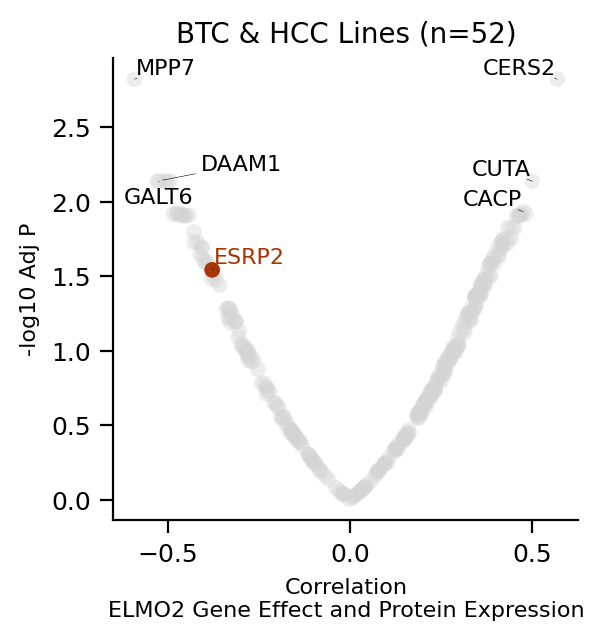

feature       ESRP2
corr      -0.378608
p-value    0.005646
q-value    0.028626
color       #A63603
Name: ESRP2, dtype: object

In [54]:
selected_genes_dic = {'ESRP2':'#A63603'}
x, y = Utils.match_rows_df(all_gene_effect_df[[gene]], all_proteomics_mad_df[hypotheses_l])
corr_res_df = Utils.statistical_test_and_volcano_plot(x[[gene]], y, col=gene, test='correlation', xlabel='Correlation\nELMO2 Gene Effect and Protein Expression',  force_points=.6, force_text=1., selected_genes_dic=selected_genes_dic, cut_off_labels=3, save_file=f'BTC&HCC_{gene}_gene_effect_corr_rna.csv',  title=f'BTC & HCC Lines (n={y.shape[0]})', axis_label_fontsize=8)
corr_res_df.loc['ESRP2',:]

## FERMT1 vs FERMT2 (FERM2)

p-value:  3.4798613784575005e-06


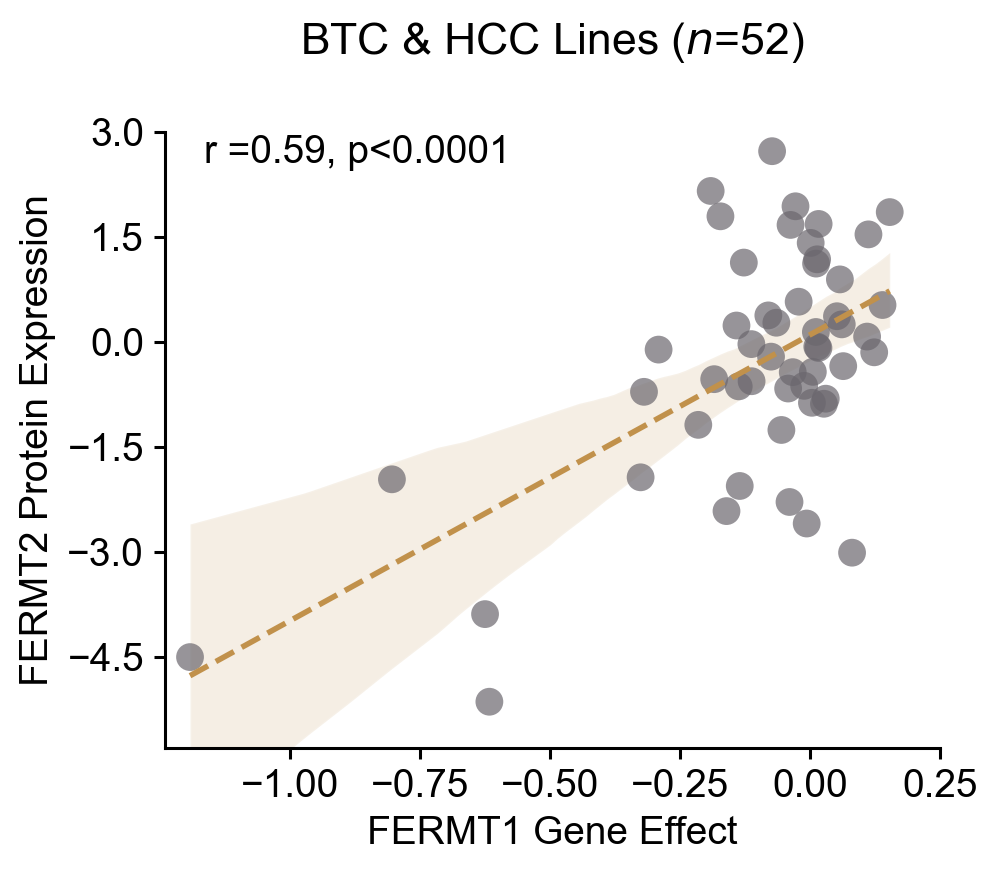

In [55]:
x_gene = 'FERMT1'
y_gene =  'FERM2'
x, y = Utils.match_rows_df(all_gene_effect_df[[x_gene]], all_proteomics_mad_df[[y_gene]])
df = pd.concat([x, y], axis=1)
df = df.dropna(axis=0)
df.columns=['gene_effect', 'protein']

MyVisualization.reg_plot(data_df=df, x_col='gene_effect', y_col='protein', title=f'BTC & HCC Lines ($n$={df.shape[0]})', points_color_code=points_color, line_color_code=line_color, xlabel=f'{x_gene} Gene Effect',  ylabel=f"{proteomics_key_df.loc[y_gene, 'GeneName']} Protein Expression", marker='o', title_height=1.1, text_height=.95,  ytick_step=1.5, xtick_step=0.25, ylim_top=3,ylim_bottom=-5.8 , xlim_left=-1.24, xlim_right=.25,file_name=f'{x_gene}_{y_gene}_protein')

## FERMT1 vs FERMT2

p-value:  1.372052717634481e-06


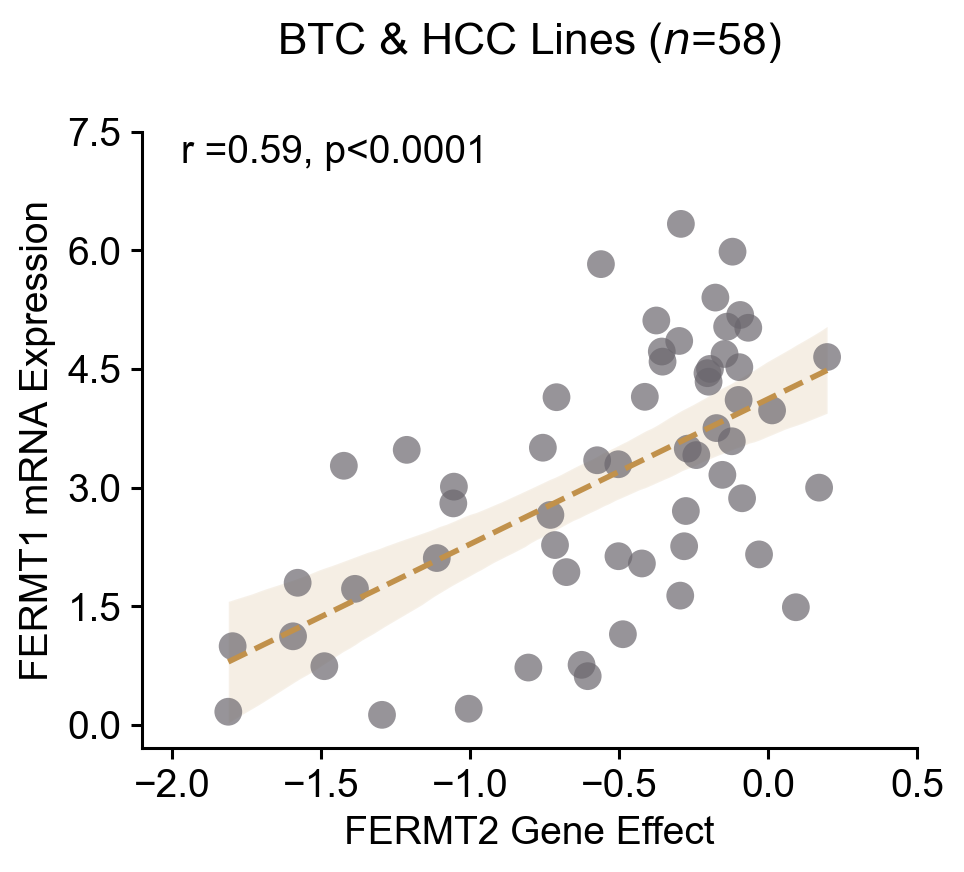

In [56]:
x_gene = 'FERMT2'
y_gene = 'FERMT1'
y, x = Utils.match_rows_df(all_rna_df[[y_gene]], all_gene_effect_df[[x_gene]])
df = pd.concat([y, x], axis=1)

MyVisualization.reg_plot(data_df=df, x_col=x_gene, y_col=y_gene, title=f'BTC & HCC Lines ($n$={df.shape[0]})', points_color_code=points_color, line_color_code=line_color, xlabel=f'{x_gene} Gene Effect',  ylabel=f'{y_gene} mRNA Expression', marker='o', title_height=1.1, text_height=.95,  xlim_right=.5, ytick_step=1.5, ylim_top=7.5, xlim_left=-2.1, file_name=f'{x_gene}_{y_gene}_mrna')

## TEAD1: RNA

p-value:  0.11405238390445328


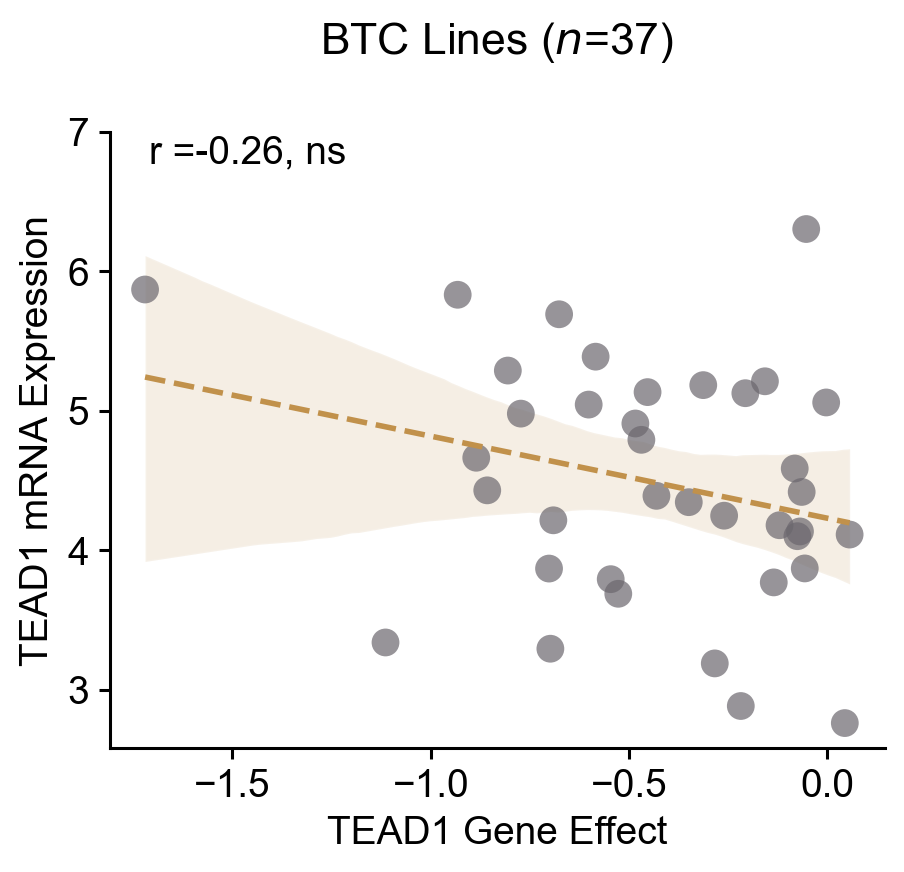

In [57]:
gene = 'TEAD1'
x, y = Utils.match_rows_df(gene_effect_df[[gene]], rna_df[[gene]])
df = pd.concat([x, y], axis=1)
df.columns=['gene_effect', 'mrna']

MyVisualization.reg_plot(data_df=df, x_col='gene_effect', y_col='mrna', title=f'BTC Lines ($n$={df.shape[0]})', points_color_code=points_color, line_color_code=line_color, xlabel=f'{gene} Gene Effect',  ylabel=f'{gene} mRNA Expression', marker='o', title_height=1.1, text_height=.95,    xtick_step=0.5,  ytick_step=1, ylim_top=7, file_name=f'{gene}_rna')

## TEAD1: Protein

p-value:  0.005067476428772157


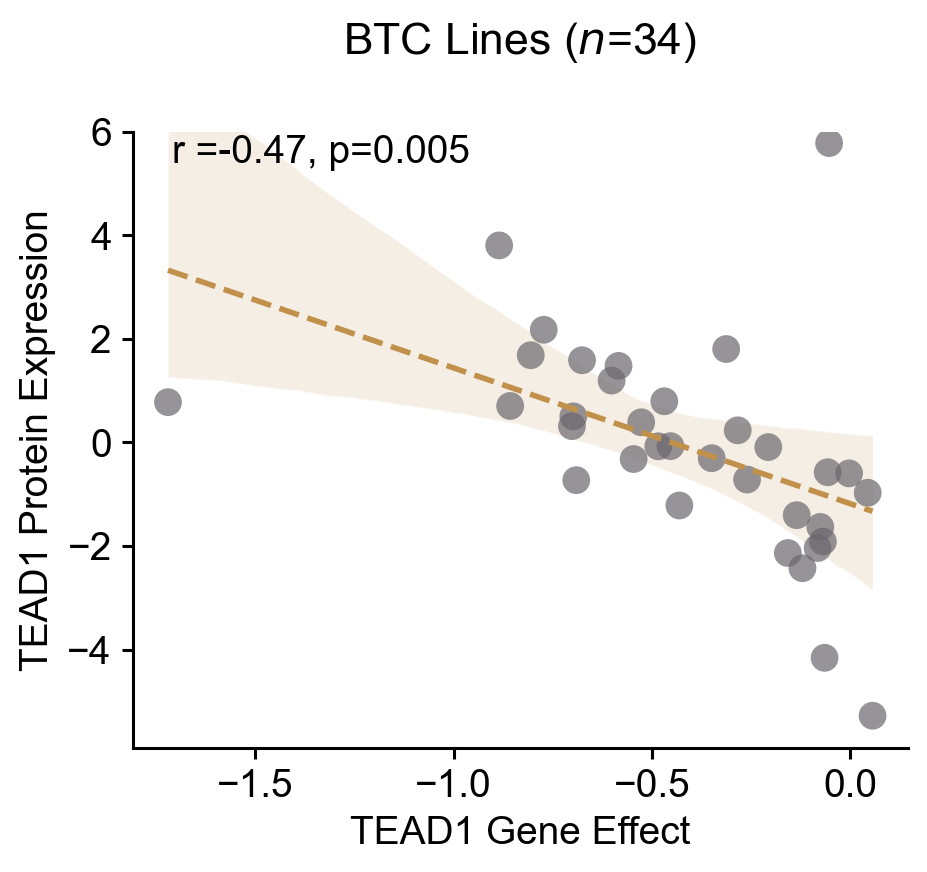

In [58]:
gene = 'TEAD1'
x, y = Utils.match_rows_df(gene_effect_df[[gene]], proteomics_mad_df[[gene]])
df = pd.concat([x, y], axis=1)
df = df.dropna(axis=0)
df.columns=['gene_effect', 'protein']

MyVisualization.reg_plot(data_df=df, x_col='gene_effect', y_col='protein', title=f'BTC Lines ($n$={df.shape[0]})', points_color_code=points_color, line_color_code=line_color, xlabel=f'{gene} Gene Effect',  ylabel=f'{gene} Protein Expression', marker='o', title_height=1.1, text_height=.95,   xtick_step=0.5, ylim_top=6, ytick_step=2, file_name=f'{gene}_protein')

## PARD3 vs TEAD1 Gene Effect

In [59]:
other_ccle_crispr_df.shape

(1061, 17107)

p-value:  0.006859750549032465
p-value:  0.02054213138618785


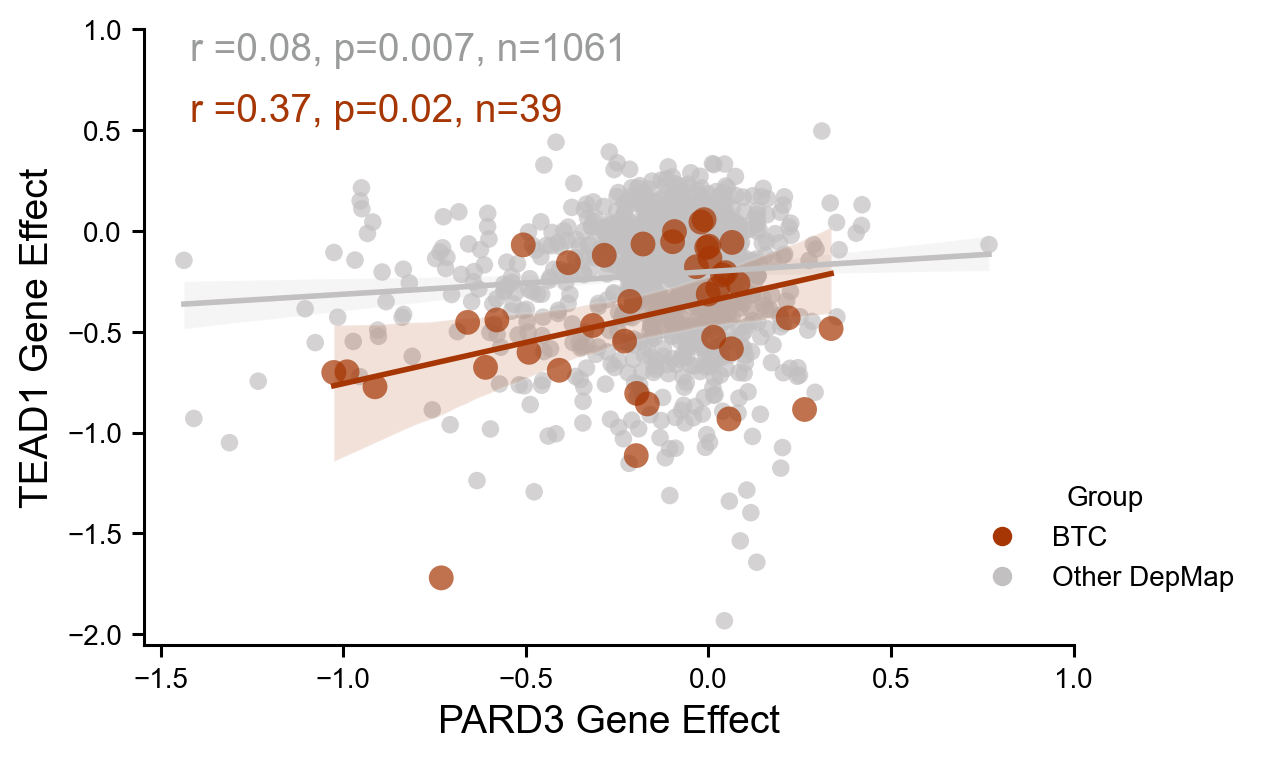

In [60]:
x_gene = 'PARD3'
y_gene = 'TEAD1'
palette = {'BTC': '#a63603', 'Other DepMap': '#c2c0c0'}
size_dic = {'BTC': 80, 'Other DepMap': 40}
markers_dic = {'BTC':'o', 'Other DepMap':'o'}

x1, y1 = Utils.match_rows_df(other_ccle_crispr_df[[x_gene]], other_ccle_crispr_df[[y_gene]])
x2, y2 = Utils.match_rows_df(gene_effect_df[[x_gene]], gene_effect_df[[y_gene]])

df1 = pd.concat([x1, y1], axis=1)
df1['Group'] = 'Other DepMap'
df1['point_size'] = .01
df2 = pd.concat([x2, y2], axis=1)
df2['Group'] = 'BTC'
df2['point_size'] = .03

df = pd.concat([df1, df2], axis=0)
MyVisualization.reg_plot_double(data_df=df, x_col=x_gene, y_col=y_gene, markers_dic=markers_dic, size_dic=size_dic, hue='Group', palette=palette, xlabel=f'PARD3 Gene Effect',  ylabel=f'TEAD1 Gene Effect', title_height=1.2, text_height=.95, ylim_top=1, xlim_right=1, file_name=f'{x_gene}_{y_gene}')

## PARD3 vs YAP1 Gene Effect

p-value:  3.813344625400356e-06
p-value:  0.07468142392600591


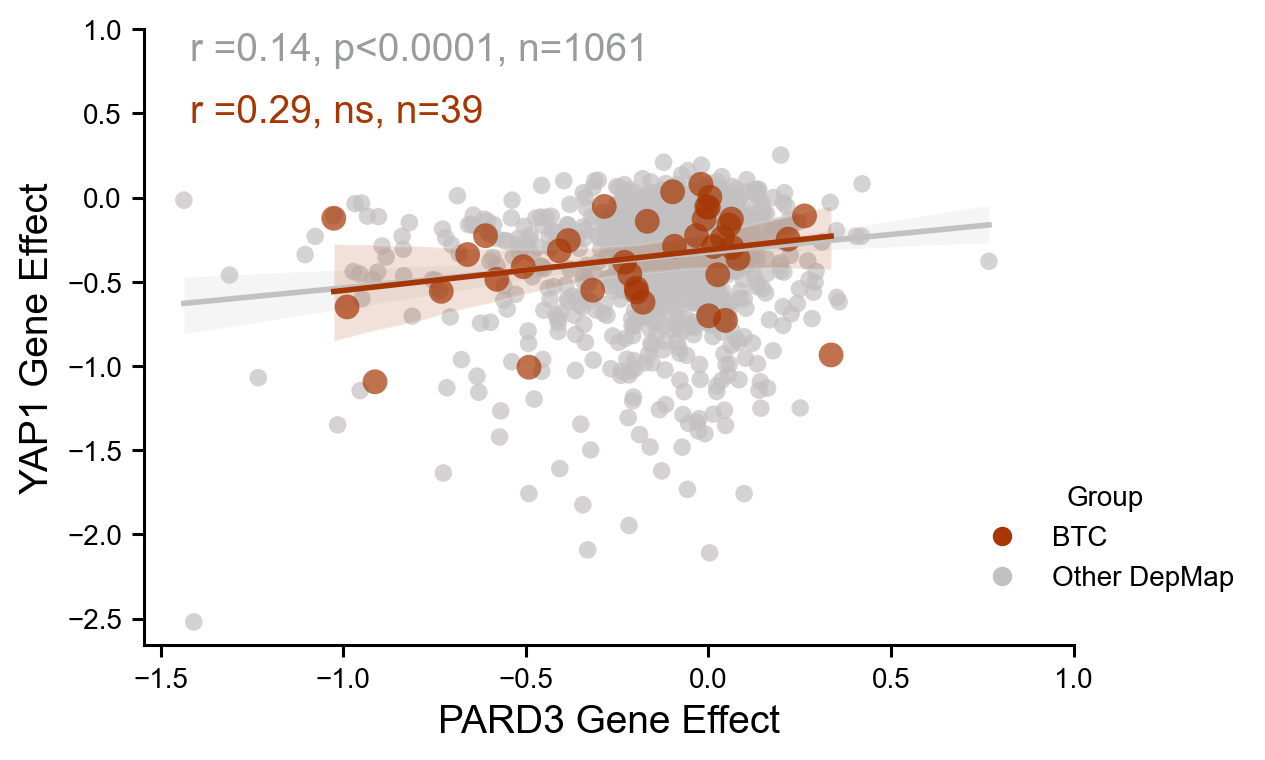

In [61]:
x_gene = 'PARD3'
y_gene = 'YAP1'
palette = {'BTC': '#a63603', 'Other DepMap': '#c2c0c0'}
size_dic = {'BTC': 80, 'Other DepMap': 40}
markers_dic = {'BTC':'o', 'Other DepMap':'o'}

x1, y1 = Utils.match_rows_df(other_ccle_crispr_df[[x_gene]], other_ccle_crispr_df[[y_gene]])
x2, y2 = Utils.match_rows_df(gene_effect_df[[x_gene]], gene_effect_df[[y_gene]])

df1 = pd.concat([x1, y1], axis=1)
df1['Group'] = 'Other DepMap'
df1['point_size'] = .01
df2 = pd.concat([x2, y2], axis=1)
df2['Group'] = 'BTC'
df2['point_size'] = .03

df = pd.concat([df1, df2], axis=0)
MyVisualization.reg_plot_double(data_df=df, x_col=x_gene, y_col=y_gene, markers_dic=markers_dic, size_dic=size_dic, hue='Group', palette=palette, xlabel=f'PARD3 Gene Effect',  ylabel=f'YAP1 Gene Effect', title_height=1.2, text_height=.95, ylim_top=1, xlim_right=1, file_name=f'{x_gene}_{y_gene}')

## PARD3: RNA

p-value:  0.6673603382328879


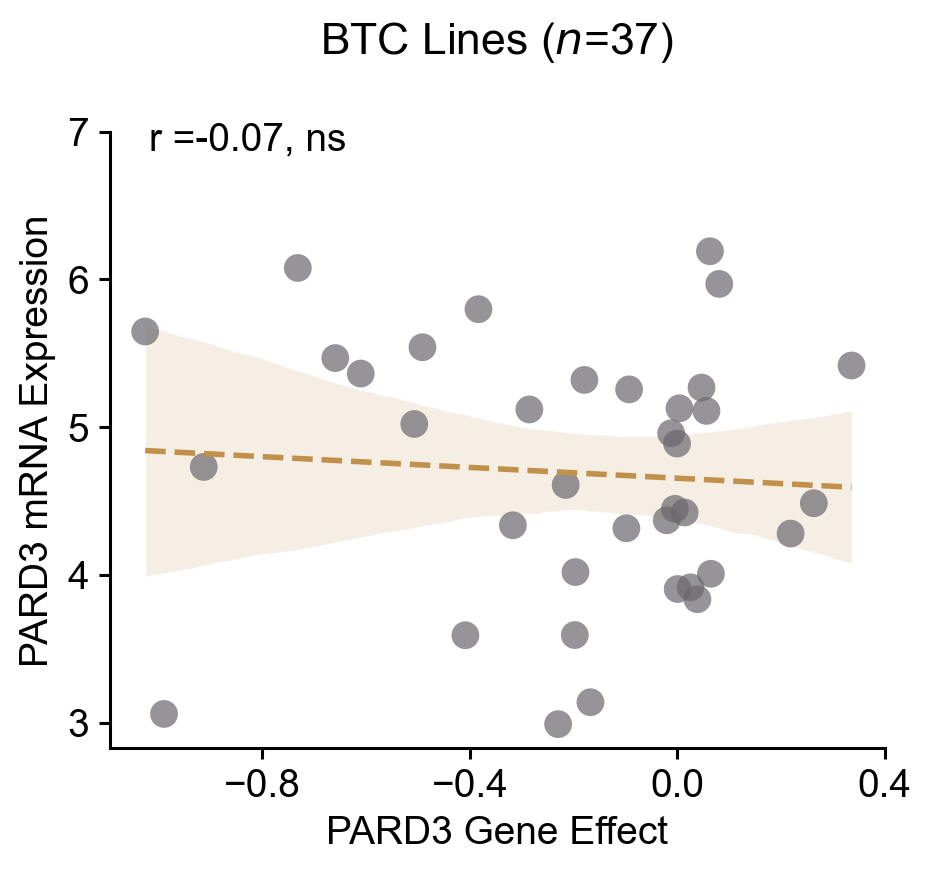

In [62]:
gene = 'PARD3'
x, y = Utils.match_rows_df(gene_effect_df[[gene]], rna_df[[gene]])
df = pd.concat([x, y], axis=1)
df.columns=['gene_effect', 'mrna']

MyVisualization.reg_plot(data_df=df, x_col='gene_effect', y_col='mrna', title=f'BTC Lines ($n$={df.shape[0]})', points_color_code=points_color, line_color_code=line_color, xlabel=f'{gene} Gene Effect',  ylabel=f'{gene} mRNA Expression', marker='o', title_height=1.1, text_height=.97, ylim_top=7, ytick_step=1, xtick_step=.4, xlim_right=.4, file_name=f'{gene}_rna')

## PARD3: Protein

p-value:  0.025786774832324087


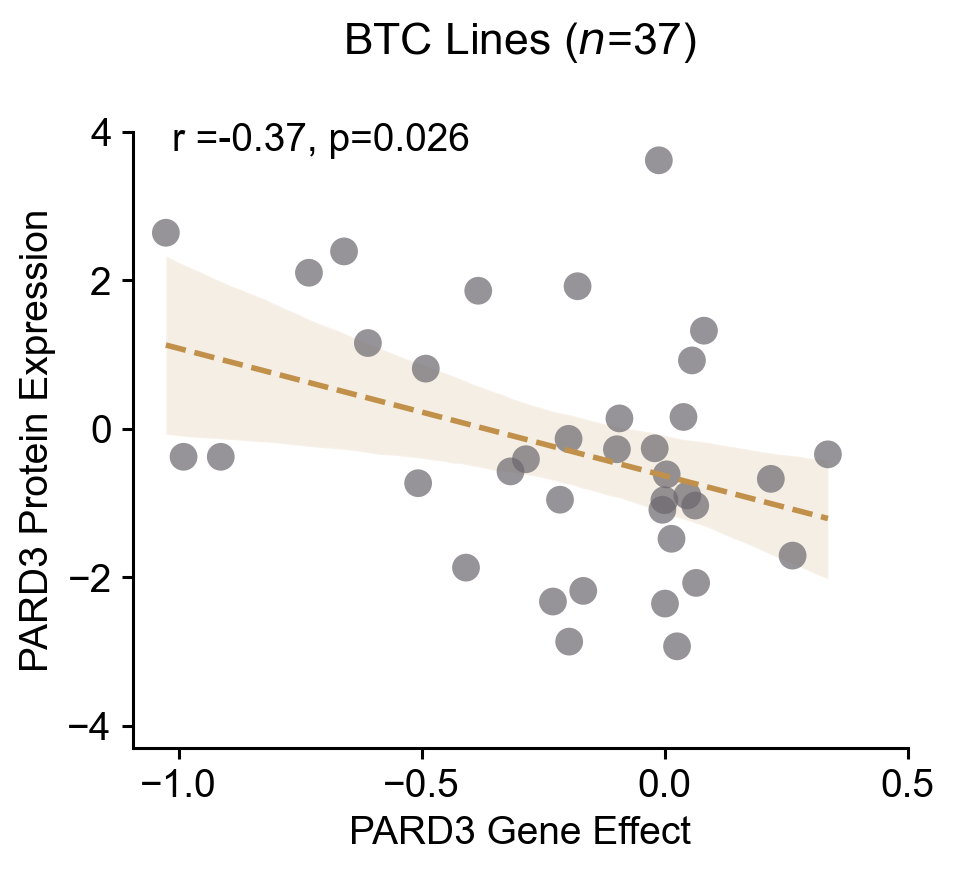

In [63]:
gene = 'PARD3'
x, y = Utils.match_rows_df(gene_effect_df[[gene]], proteomics_mad_df[[gene]])
df = pd.concat([x, y], axis=1)
df = df.dropna(axis=0)
df.columns=['gene_effect', 'protein']

MyVisualization.reg_plot(data_df=df, x_col='gene_effect', y_col='protein', title=f'BTC Lines ($n$={df.shape[0]})', points_color_code=points_color, line_color_code=line_color, xlabel=f'{gene} Gene Effect',  ylabel=f'{gene} Protein Expression', marker='o', title_height=1.1, text_height=.97, ytick_step=2, xtick_step=0.5, ylim_top=4, ylim_bottom=-4.3, xlim_right=.5, file_name=f'{gene}_protein')

## PARD6B / PAR6B: RNA

p-value:  0.0003191858774613923


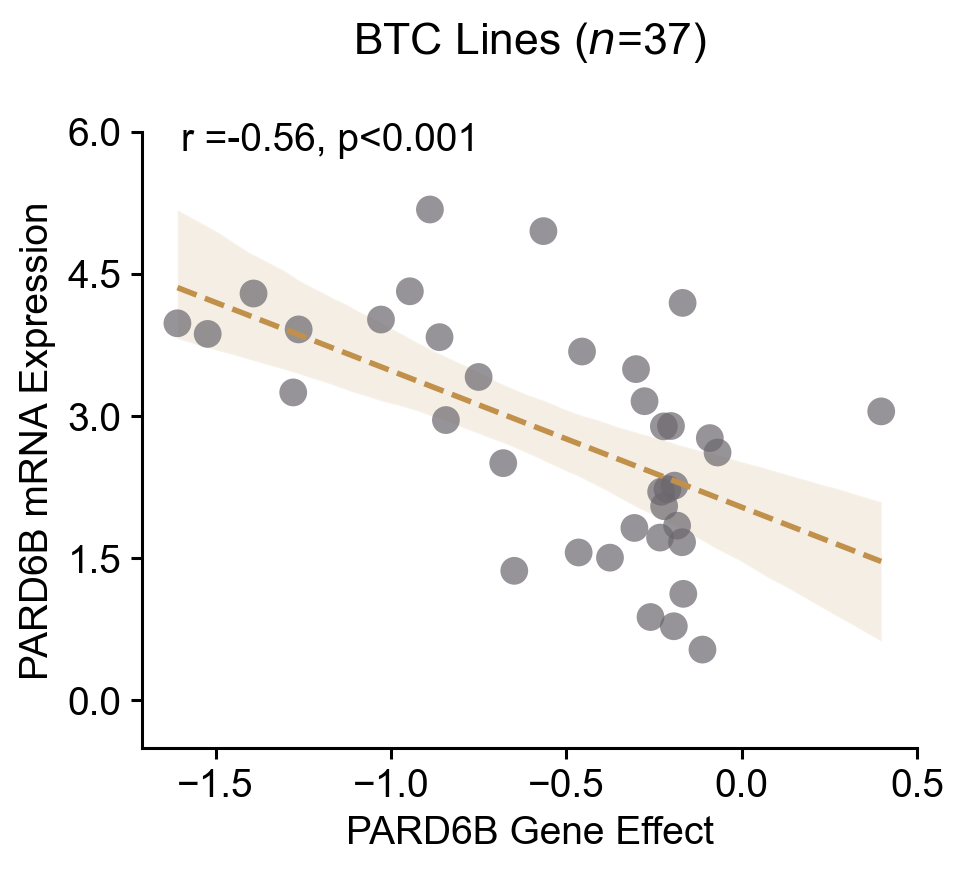

In [64]:
gene = 'PARD6B'
x, y = Utils.match_rows_df(gene_effect_df[[gene]], rna_df[[gene]])
df = pd.concat([x, y], axis=1)
df.columns=['gene_effect', 'mrna']

MyVisualization.reg_plot(data_df=df, x_col='gene_effect', y_col='mrna', title=f'BTC Lines ($n$={df.shape[0]})', points_color_code=points_color, line_color_code=line_color, xlabel=f'{gene} Gene Effect',  ylabel=f'{gene} mRNA Expression', marker='o', title_height=1.1, text_height=.97, ylim_bottom=-0.5, ylim_top=6, ytick_step=1.5, xlim_right=.5, file_name=f'{gene}_rna')

## PARD6B / PAR6B: Protein

p-value:  0.0051178865348506285


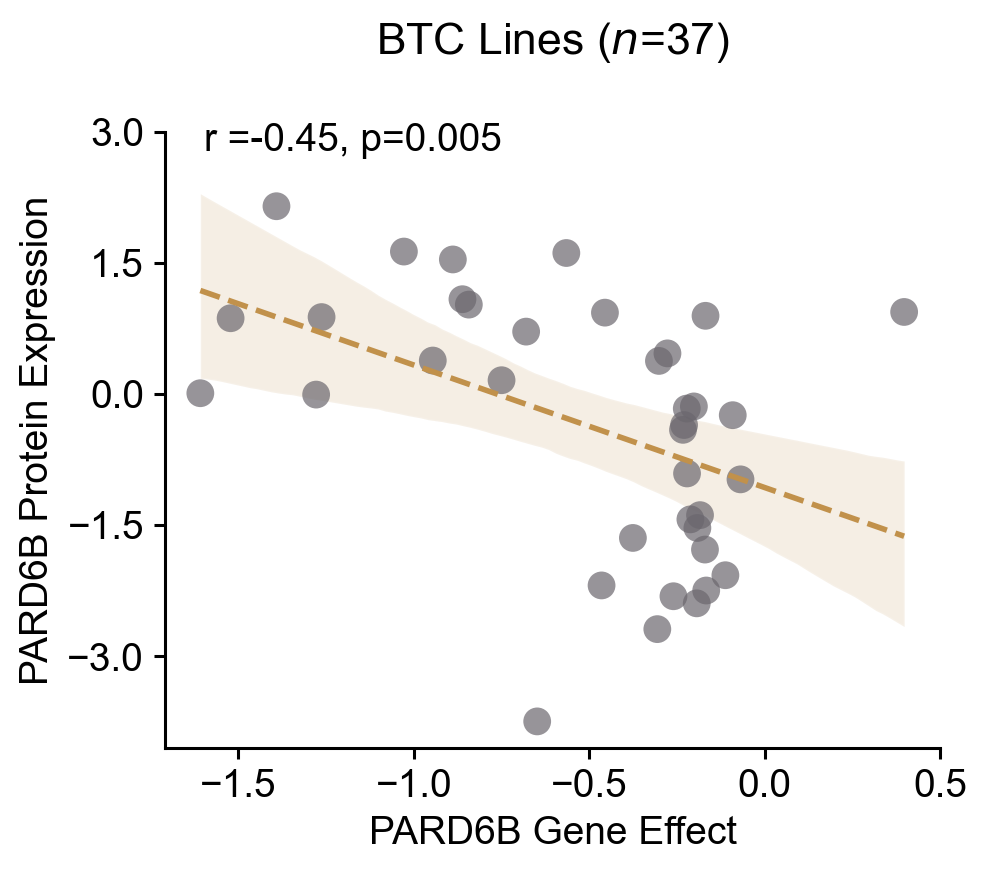

In [65]:
x_gene = 'PARD6B'
y_gene = 'PAR6B'
x, y = Utils.match_rows_df(gene_effect_df[[x_gene]], proteomics_mad_df[[y_gene]])
df = pd.concat([x, y], axis=1)
df = df.dropna(axis=0)
df.columns=['gene_effect', 'protein']

MyVisualization.reg_plot(data_df=df, x_col='gene_effect', y_col='protein', title=f'BTC Lines ($n$={df.shape[0]})', points_color_code=points_color, line_color_code=line_color, xlabel=f'{x_gene} Gene Effect',  ylabel=f'{x_gene} Protein Expression', marker='o', title_height=1.1, text_height=.97, xlim_right=.5, ylim_top=3., ytick_step=1.5,  file_name=f'{x_gene}_protein')

## WWTR1: RNA 

p-value:  0.06620879620313484


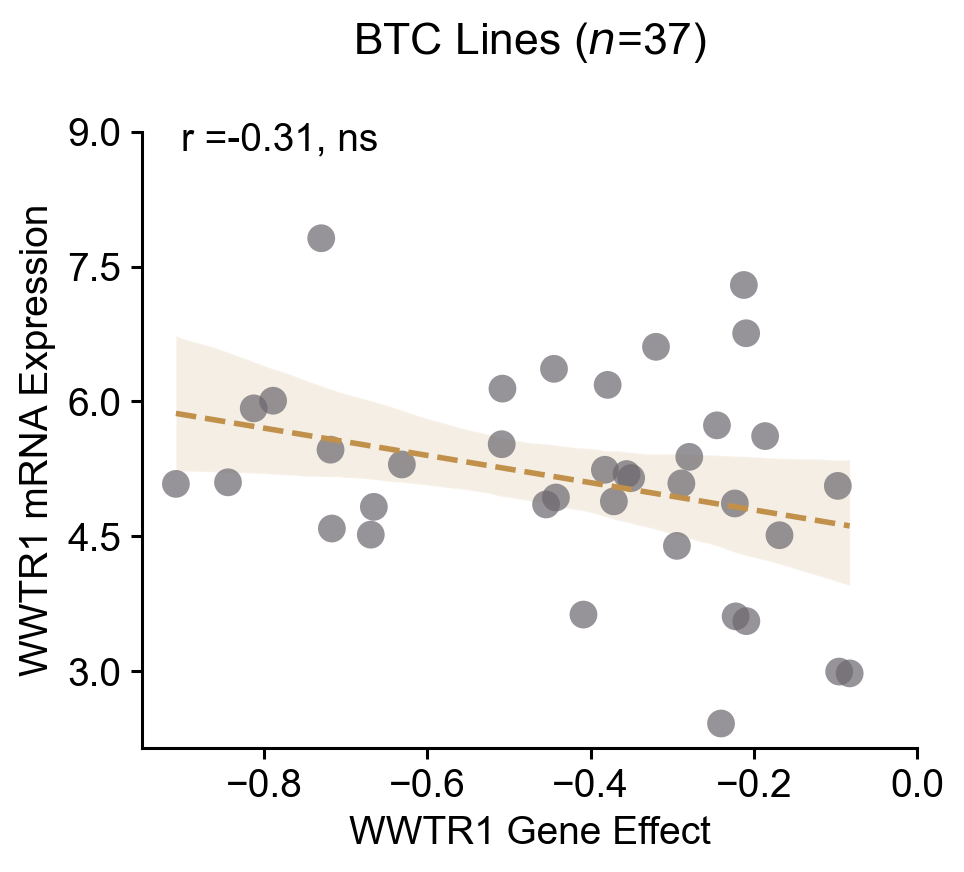

In [66]:
gene = 'WWTR1'
x, y = Utils.match_rows_df(gene_effect_df[[gene]], rna_df[[gene]])
df = pd.concat([x, y], axis=1)
df.columns=['gene_effect', 'mrna']

MyVisualization.reg_plot(data_df=df, x_col='gene_effect', y_col='mrna', title=f'BTC Lines ($n$={df.shape[0]})', points_color_code=points_color, line_color_code=line_color, xlabel=f'{gene} Gene Effect',  ylabel=f'{gene} mRNA Expression', marker='o', title_height=1.1, text_height=.97, xlim_right=0, ylim_top=9, ytick_step=1.5, file_name=f'{gene}_rna')

## WWTR1: Protein

p-value:  0.027292993350864013


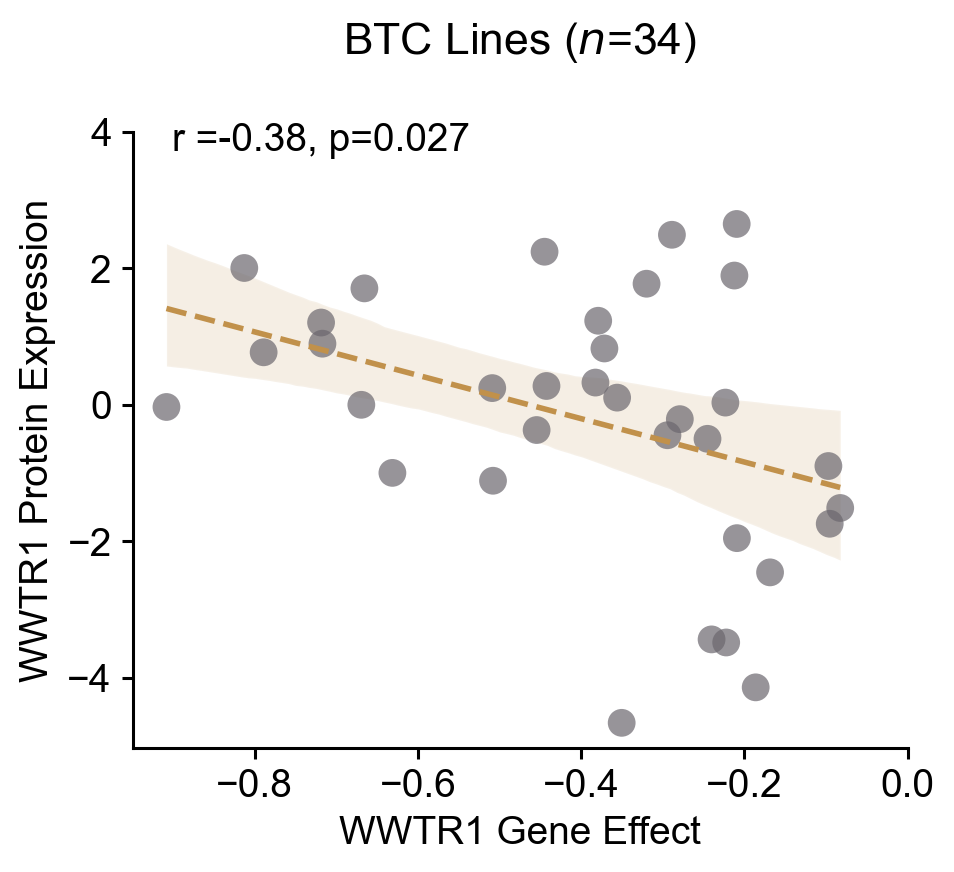

In [67]:
gene = 'WWTR1'
x, y = Utils.match_rows_df(gene_effect_df[[gene]], proteomics_mad_df[[gene]])
df = pd.concat([x, y], axis=1)
df = df.dropna(axis=0)
df.columns=['gene_effect', 'protein']

MyVisualization.reg_plot(data_df=df, x_col='gene_effect', y_col='protein', title=f'BTC Lines ($n$={df.shape[0]})', points_color_code=points_color, line_color_code=line_color, xlabel=f'{gene} Gene Effect',  ylabel=f'{gene} Protein Expression', marker='o', title_height=1.1, text_height=.97, xlim_right=0, ylim_top=4, ytick_step=2, file_name=f'{gene}_protein')

## ELMO2: RNA

p-value:  0.10450692714767745


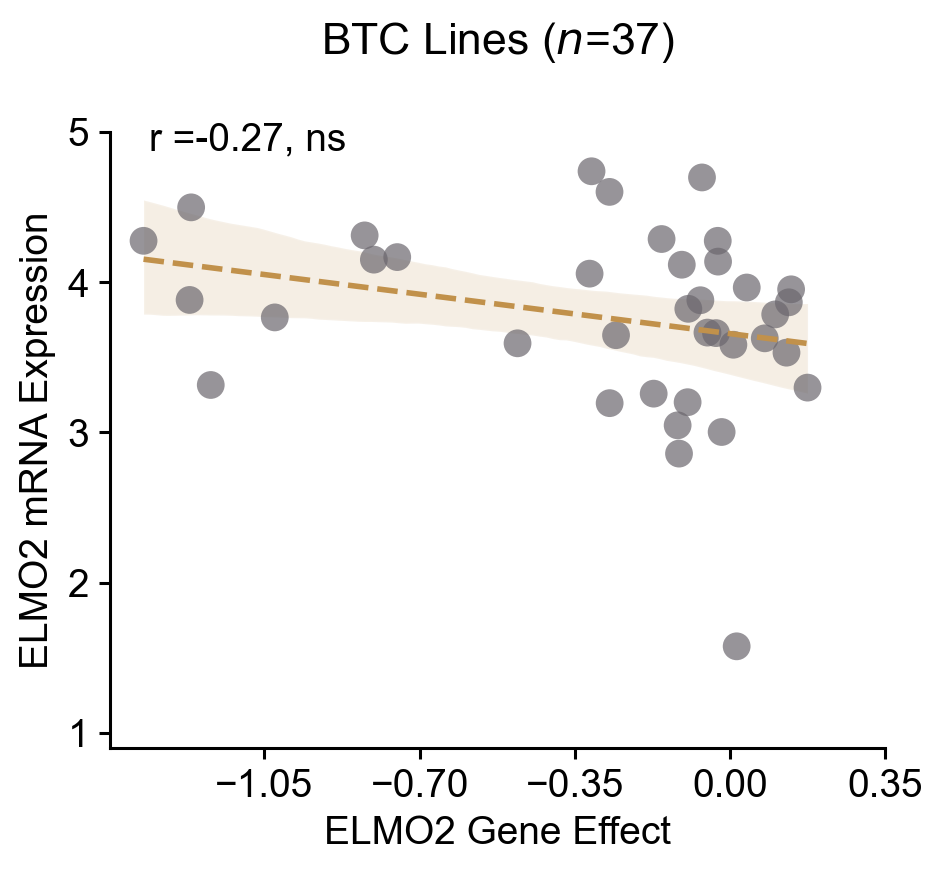

In [68]:
gene = 'ELMO2'
x, y = Utils.match_rows_df(gene_effect_df[[gene]], rna_df[[gene]])
df = pd.concat([x, y], axis=1)
df.columns=['gene_effect', 'mrna']

MyVisualization.reg_plot(data_df=df, x_col='gene_effect', y_col='mrna', title=f'BTC Lines ($n$={df.shape[0]})', points_color_code=points_color, line_color_code=line_color, xlabel=f'{gene} Gene Effect',  ylabel=f'{gene} mRNA Expression', marker='o', title_height=1.1, text_height=.97,xlim_right=0.35, xtick_step=.35, ylim_top=5, ytick_step=1., ylim_bottom=.9)

## ELMO2: Protein

p-value:  5.0517189582565356e-05


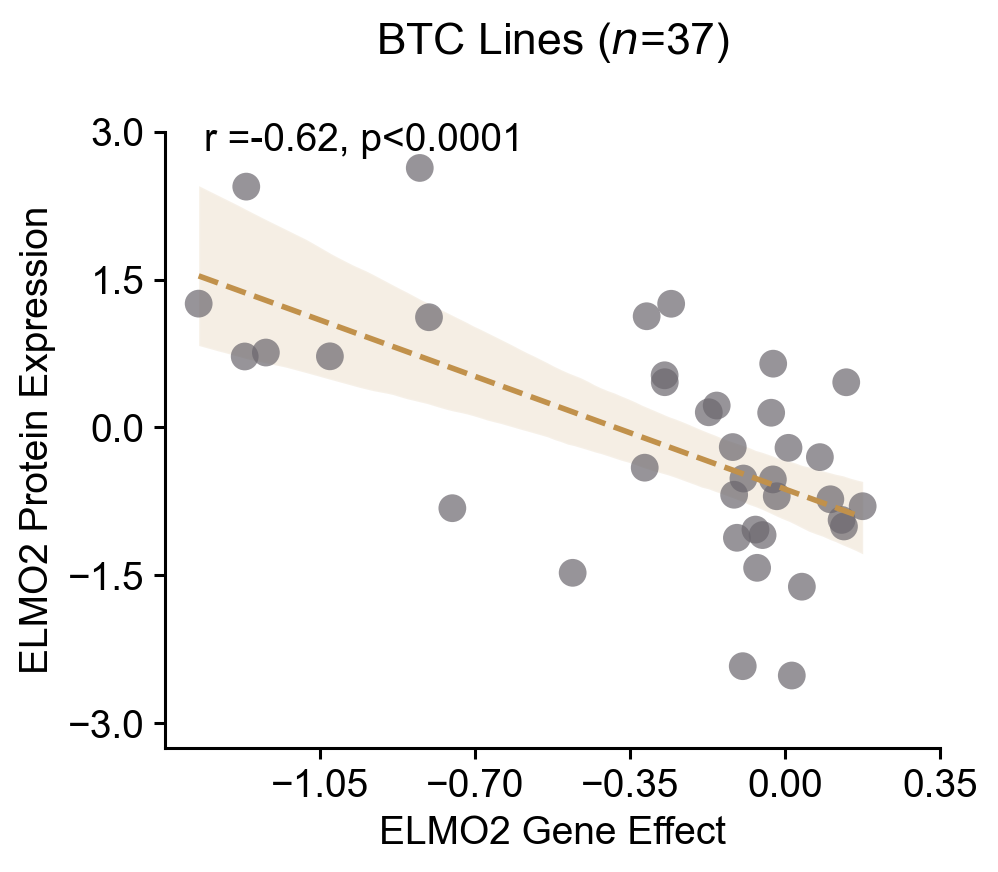

In [69]:
gene = 'ELMO2'
x, y = Utils.match_rows_df(gene_effect_df[[gene]], proteomics_mad_df[[gene]])
df = pd.concat([x, y], axis=1)
df = df.dropna(axis=0)
df.columns=['gene_effect', 'protein']

MyVisualization.reg_plot(data_df=df, x_col='gene_effect', y_col='protein', title=f'BTC Lines ($n$={df.shape[0]})', points_color_code=points_color, line_color_code=line_color, xlabel=f'{gene} Gene Effect',  ylabel=f'{gene} Protein Expression', marker='o', title_height=1.1, text_height=.97,xlim_right=0.35, xtick_step=.35, ylim_top=3, ytick_step=1.5,  ylim_bottom=-3.25)

## FERMT2: RNA

p-value:  0.01923991302346743


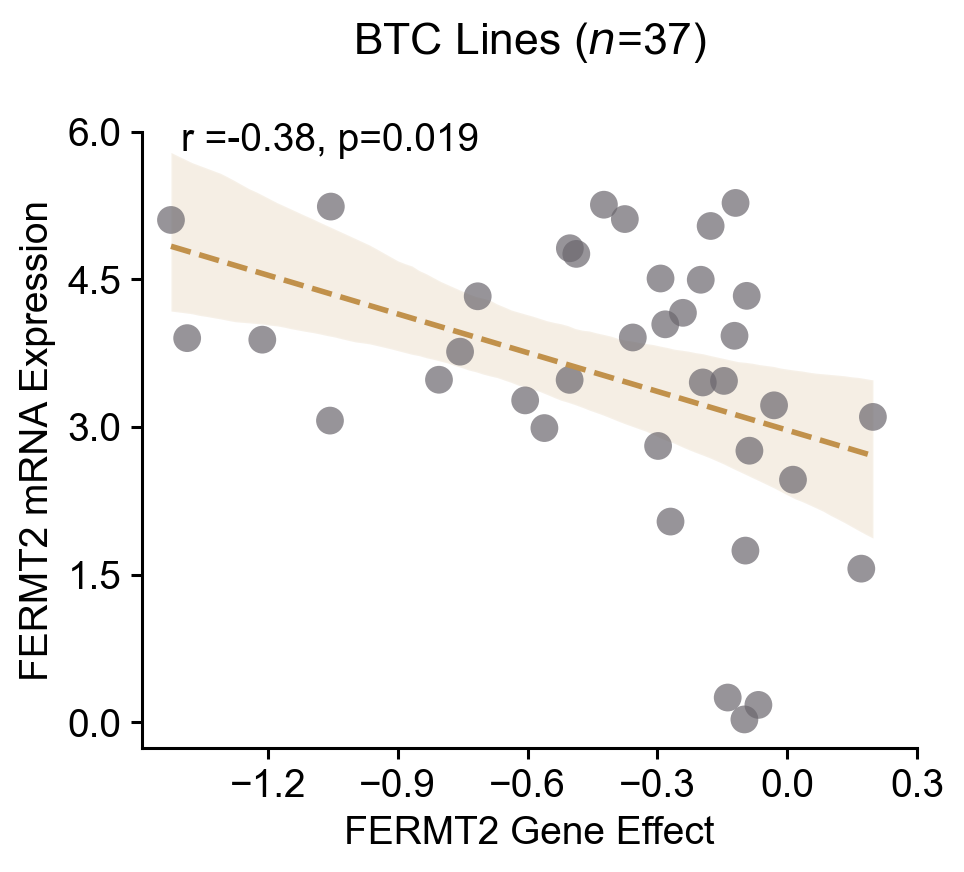

In [70]:
gene = 'FERMT2'
x, y = Utils.match_rows_df(gene_effect_df[[gene]], rna_df[[gene]])
df = pd.concat([x, y], axis=1)
df.columns=['gene_effect', 'mrna']

MyVisualization.reg_plot(data_df=df, x_col='gene_effect', y_col='mrna', title=f'BTC Lines ($n$={df.shape[0]})', points_color_code=points_color, line_color_code=line_color, xlabel=f'{gene} Gene Effect',  ylabel=f'{gene} mRNA Expression', marker='o', title_height=1.1, text_height=.97, xlim_right=0.3, xlim_left=-1.49, xtick_step=.3, ylim_top=6, ytick_step=1.5)

## FERMT2: Protein

p-value:  0.007615521705841684


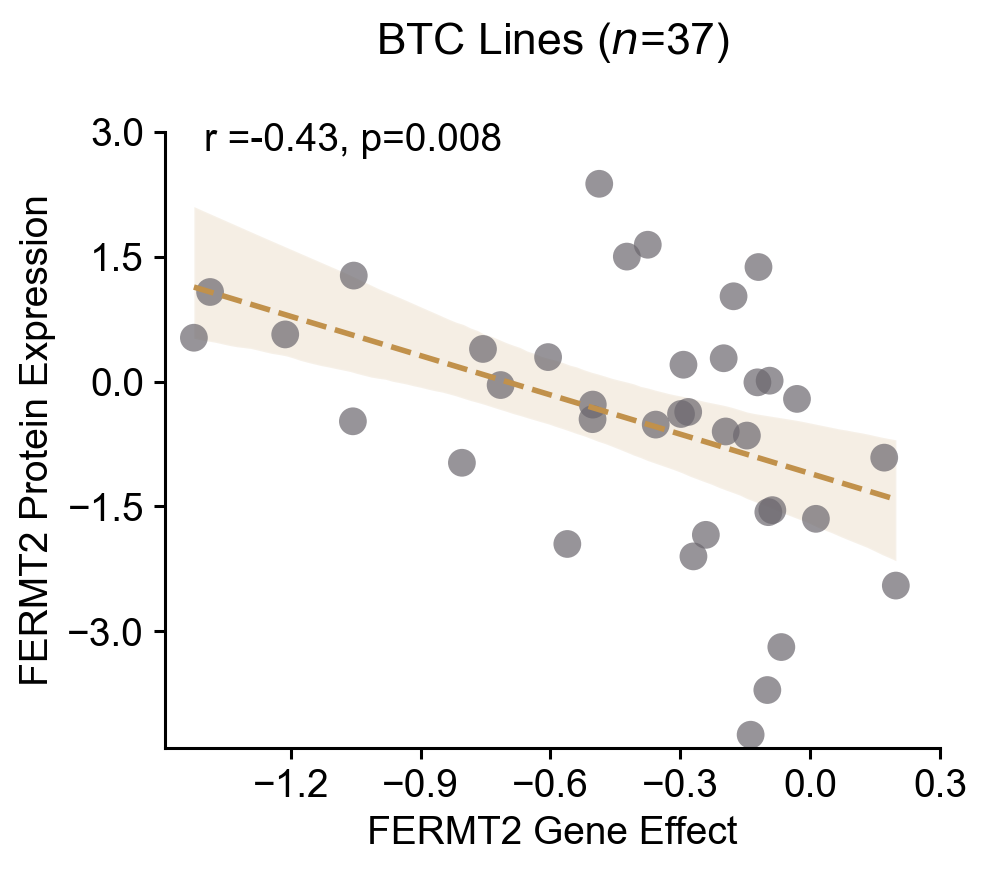

In [71]:
gene = 'FERMT2'
x, y = Utils.match_rows_df(gene_effect_df[[gene]], proteomics_mad_df[['FERM2']])
df = pd.concat([x, y], axis=1)
df = df.dropna(axis=0)
df.columns=['gene_effect', 'protein']

MyVisualization.reg_plot(data_df=df, x_col='gene_effect', y_col='protein', title=f'BTC Lines ($n$={df.shape[0]})', points_color_code=points_color, line_color_code=line_color, xlabel=f'{gene} Gene Effect',  ylabel=f'{gene} Protein Expression', marker='o', title_height=1.1, text_height=.97, xlim_right=0.3, xlim_left=-1.49, xtick_step=.3, ylim_top=3, ytick_step=1.5, ylim_bottom= -4.4)

# Correlation heatmap

In [72]:
gene_effect_df.shape

(39, 17787)

In [73]:
genes_l = ['PARD3', 'PARD6B', 'WWTR1', 'TEAD1', 'ELMO2', 'FERMT2']
df = gene_effect_df[genes_l]
df

Gene,PARD3,PARD6B,WWTR1,TEAD1,ELMO2,FERMT2
Cell_line,,,,,,
SNU869,-0.093073,-0.277271,-0.209542,-0.003127,0.101694,0.170837
SNU478,0.046584,-0.221435,-0.222403,-0.206901,-0.051060,-0.093828
TGBC52TKB,0.263111,-0.166796,-0.788963,-0.885299,-1.215110,-0.119593
AOVC1,-0.913131,-1.522462,-0.669307,-0.772882,-0.067056,-1.212668
TGBC18TKB,-0.032938,-0.285364,-0.222120,-0.177636,0.071329,-0.011814
SNU1196,-0.000613,-0.301539,-0.508955,-0.313009,-0.271884,-0.137726
EGI1,-0.197754,-0.680062,-0.408802,-1.114052,-0.095791,-0.087588
KKU100,-0.229859,-0.193786,-0.665550,-0.546330,-0.823931,-1.386196
TFK1,0.062797,-0.201928,-0.288873,-0.584364,0.007368,-0.241125


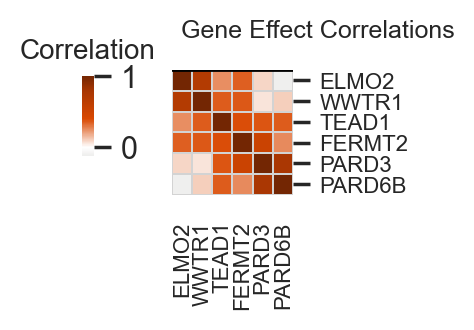

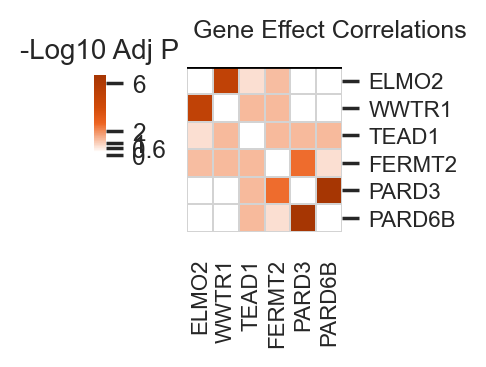


File  Figure6/output_fig6/top_proteins_gene_effect_correlations_correlations.csv saved, shape: (15, 5)


In [74]:
Utils.apply_correlations_pairwise(df, df, index_name='Gene', title='Gene Effect Correlations', filename='top_proteins_gene_effect_correlations')